# **Airbnb rentals prices and the proximity to cultural sites: is there a correlation?**
## A short analysis of how proximity to an art galley, museum or other cultural center might influence the price you pay per night for your  Airbnb
Location is one of the most important features a short-term rental property could offer to the avid voyager. Using information about Seattle's Airbnb listings from the website [Inside Airbnb](http://insideairbnb.com/) and the inventory of cultural sites from [Seattle's Open Data Portal](https://data.seattle.gov/), we will try to discover any interesting spatial patterns between these two datasets. Let's get started!

To get a good overview of the potential spatial relationships, I will try to answer the following questions:
1. Are the Airbnb units located in neighborhoods that have more cultural sites, charging also more per night?
2. In terms of proximity to cultural sites, how Airbnb units
3. Is there a correlation between price per night and the proximity to city's cultural sites?

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px


In [4]:
# Import the listings and cultural sites datasets
listings = pd.read_csv('data/listings.csv')
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [25]:
# Data review
print('Column names\n', '----------\n', listings.columns)
print('Null values\n', '----------\n', listings.isna().sum().sort_values(ascending=False))

Column names
 ----------
 Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 

In [5]:
cultural = pd.read_csv('data/Seattle_Cultural_Space_Inventory.csv')
cultural.head(3)

,Name,Phone,URL,Square Feet Total,Neighborhood,Organization Type,Dominant Discipline,Year of Occupation,Rent vs Own,Age of Current Building,...,Constituency over 50% one race,Specific Demographics and Community,Organization Leadership,Organization Artists,Closed Date,Closed?,Address,Location,Latitude,Longitude
0,Bootstrap Music,NaN,NaN,NaN,NaN,NaN,Studios,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Chinese Information and Service Center,NaN,NaN,NaN,NaN,NaN,Community Center,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,611 S Lane St Seattle WA 98104,"(47.596665, -122.325649)",47.596665,-122.325649
2,Gallery AXIS,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,308 1st Ave S,"(47.599804, -122.333995)",47.599804,-122.333995


In [24]:
# Data review
print('Column names\n', '----------\n', cultural.columns)
print('Null values\n', '----------\n', cultural.isna().sum().sort_values(ascending=False))

Column names
 ----------
 Index(['Name', 'Phone', 'URL', 'Square Feet Total', 'Neighborhood',
       'Organization Type', 'Dominant Discipline', 'Year of Occupation',
       'Rent vs Own', 'Age of Current Building', 'Length of Lease (Date)',
       ' Year Organization Founded', 'Number of Past Facilities',
       'Stages and Theaters', 'Stage & Theater Seats ', 'Gallery Space',
       'Gallery Square Feet', 'ADA Compliant', 'Available Parking',
       'Street Presence', 'Rental Space ', 'Alcohol Sales',
       'Organization Mission', 'Funded by A&C', 'Funded by 4Culture',
       'Stability Index (5=very stable, 1=very uncertain)',
       'Control Index (5=very in control, 1 = very out of control) ',
       'Constituency over 50% one race', 'Specific Demographics and Community',
       'Organization Leadership', 'Organization Artists', 'Closed Date',
       'Closed?', 'Address', 'Location', 'Latitude', 'Longitude'],
      dtype='object')
Null values
 ----------
 Organization Artists    

In [11]:
# verify the number of null values
null_count = listings.isna().sum().sort_values(ascending=False)
for i, v in null_count.items():
    if v > 0:
        print(i, ':', v, 'nulls')

license : 3818 nulls
square_feet : 3721 nulls
monthly_price : 2301 nulls
security_deposit : 1952 nulls
weekly_price : 1809 nulls
notes : 1606 nulls
neighborhood_overview : 1032 nulls
cleaning_fee : 1030 nulls
transit : 934 nulls
host_about : 859 nulls
host_acceptance_rate : 773 nulls
review_scores_accuracy : 658 nulls
review_scores_checkin : 658 nulls
review_scores_value : 656 nulls
review_scores_location : 655 nulls
review_scores_cleanliness : 653 nulls
review_scores_communication : 651 nulls
review_scores_rating : 647 nulls
last_review : 627 nulls
first_review : 627 nulls
reviews_per_month : 627 nulls
space : 569 nulls
host_response_rate : 523 nulls
host_response_time : 523 nulls
neighbourhood : 416 nulls
thumbnail_url : 320 nulls
medium_url : 320 nulls
xl_picture_url : 320 nulls
host_neighbourhood : 300 nulls
summary : 177 nulls
bathrooms : 16 nulls
host_location : 8 nulls
zipcode : 7 nulls
bedrooms : 6 nulls
host_name : 2 nulls
host_listings_count : 2 nulls
host_since : 2 nulls
hos

In [14]:
# Visualize listings locations
px.scatter_mapbox(data_frame=listings, lat='latitude', lon='longitude', zoom=9, mapbox_style='carto-positron')

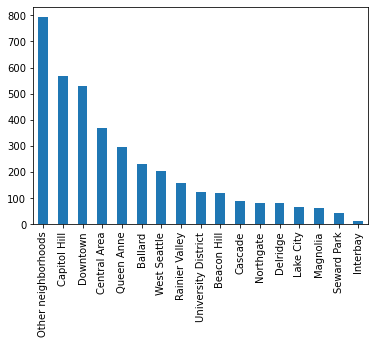

In [16]:
# number of listings per neighborhood group
listings['neighbourhood_group_cleansed'].value_counts().plot(kind='bar');

In [48]:
tmp_price[1].dtypes

dtype('O')

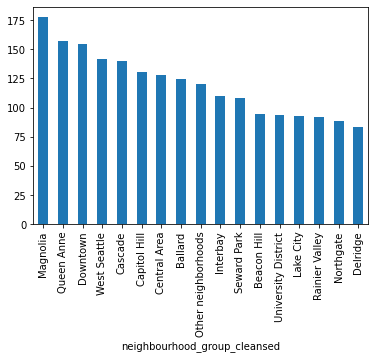

In [50]:
# average price-per-night by neighbouthoob group
tmp_price = listings['price'].str.split('$', expand=True)
listings['price_cleansed'] = tmp_price[1].str.replace(',', '').astype('float')
listings.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False).plot(kind='bar');

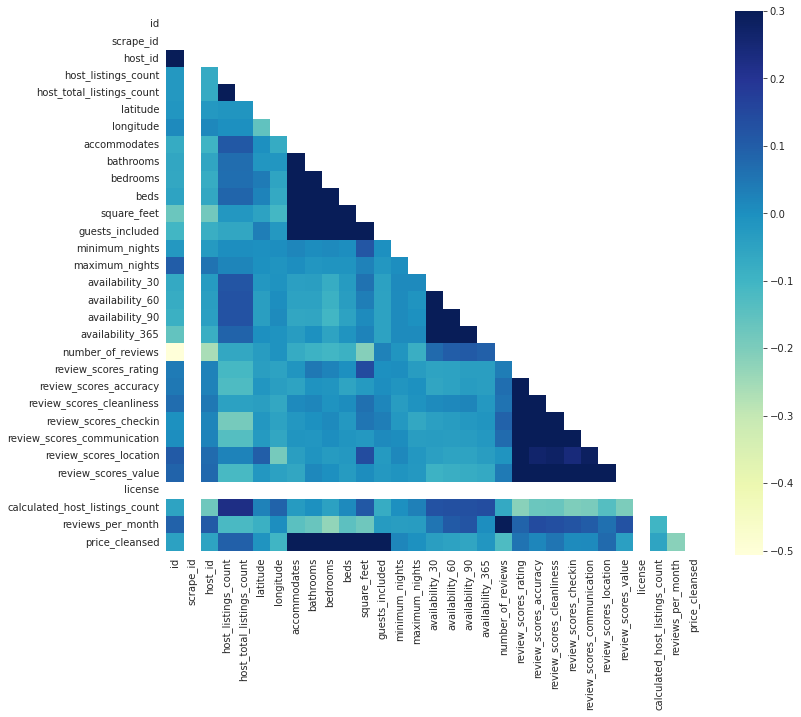

In [52]:
# correlation between variables using a heatmap
corr = listings.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=0.3, square=True, cmap='YlGnBu');

<AxesSubplot:xlabel='accommodates'>

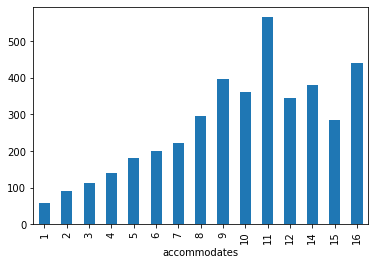

In [68]:
listings.groupby('accommodates')['price_cleansed'].mean().plot(kind='bar')

In [55]:
# listings locations
import folium
# sns.scatterplot(x=listings['longitude'], y=listings['latitude']);

# Folium map
m = folium.Map(listings[['latitude', 'longitude']].mean().to_list(), tiles="cartodb positron", zoom_start=9)

# add all points
for index, row in listings.iterrows():
    folium.Marker(location=row[['latitude', 'longitude']].to_list()).add_to(m)

m